In [0]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import argparse, os, gzip, torch, time, pickle
import torch.nn as nn
import torch.optim as optim
import numpy as np
import imageio
import matplotlib.pyplot as plt

In [0]:
def dataloader(dataset, input_size, batch_size, split = 'train'):
  
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize([0.5], [0.5])
  ])
  
  if dataset == 'mnist':
    data_loader = DataLoader(
        datasets.MNIST('data/mnist', train = True, download = True,
                       transform = transform),
        batch_size = batch_size,
        shuffle = True
    )
    
  elif dataset == 'fashion-mnist':
    data_loader = DataLoader(
        datasets.FashionMNIST('data/fashion-mnist', train = True, download = True,
                              transform = transform),
        batch_size = batch_size,
        shuffle = True
    )
    
  elif dataset == 'cifar10':
    data_loader = DataLoader(
        datasets.CIFAR10('data/cifar10', train = True, download = True,
                         transform = transform),
        batch_size = batch_size,
        shuffle = True
    )
    
  elif dataset == 'svhn':
    data_loader = DataLoader(
        datasets.SVHN('data/svhn', split = split, download = True,
                      transform = transform),
        batch_size = batch_size,
        shuffle = True
    )
    
  elif dataset == 'stl10':
    data_loader = DataLoader(
        datasets.STL10('data/stl10', split = split, download = True,
                       transform = transform),
        batch_size = batch_size,
        shuffle = True
    )
    
  elif dataset == 'lsun-bed':
    data_loader = DataLoader(
        datasets.LSUN('data/lsun', classes = ['bedroom-train'],
                      transform = transform),
        batch_size = batch_size,
        shuffle = True
    )
    
  return data_loader

In [0]:
def load_mnist(dataset):
  data_dir = os.path.join("./data", dataset)
  
  def extract_data(filename, num_data, head_size, data_size):
    with gzip.open(filename) as bytestream:
      bytestream.read(head_size)
      buf = bytestream.read(data_size * num_data)
      data = np.frombuffer(buf, dtype = np.uint8).astype(np.float)
    return data
  
  data = extract_data(data_dir + '/train-images-idx3-ubyte.gz', 60000, 16, 28 * 28)
  trX = data.reshape((60000, 28, 28, 1))
  
  data = extract_data(data_dir + '/train-labels-idx1-ubyte.gz', 60000, 8, 1)
  trY = data.reshape((60000))
  
  data = extract_data(data_dir + '/t10k-images-idx3-ubyte.gz', 10000, 16, 28 * 28)
  teX = data.reshape((10000, 28, 28, 1))
  
  data = extract_data(data_dir + '/t10k-labels-idx1-ubyte.gz', 10000, 8, 1)
  teY = data.reshape((10000))
  
  trY = np.asarray(trY).astype(np.int)
  teY = np.asarray(teY)
  
  X = np.concatenate((trX, teX), axis = 0)
  y = np.concatenate((trY, teY), axis = 0).astype(np.int)
  
  seed = 1998
  np.random.seed(seed)
  np.random.shuffle(X)
  np.random.seed(seed)
  np.random.shuffle(y)
  
  y_vec = np.zeros((len(y), 10), dtype = np.float)
  for i, label in enumerate(y):
    y_vec[i, y[i]] = 1
  
  
  X = X.transpose(0, 3, 1, 2) / 255.
  
  X = torch.from_numpy(X).type(torch.FloatTensor)
  y_vec = torch.from_numpy(y_vec).type(torch.FloatTensor)
  return X, y_vec

In [0]:
def print_network(net):
  num_params = 0
  for param in net.parameters():
    num_params += param.numel()
  print(net)
  print('Total number of parameters: %d' % num_params)

In [0]:
def save_images(images, size, image_path):
  return imsave(images, size, image_path)

def imsave(images, size, path):
  image = np.squeeze(merge(images, size))
  return imageio.imwrite(path, image)

In [0]:
def merge(images, size):
  h, w = images.shape[1], images.shape[2]
  
  if(images.shape[3] in (3, 4)):
    c = images.shape[3]
    img = np.zeros((h * size[0], w * size[1], c))
    for idx, image in enumerate(images):
      i = idx % size[1]
      j = idx // size[1]
      img[j * h: j * h + h, i * w: i * w + w, :] = image
    return img
  
  elif images.shape[3] == 1:
    img = np.zeros((h * size[0], w * size[1]))
    for idx, image in enumerate(images):
      i = idx % size[1]
      j = idx // size[1]
      img[j * h: j * h + h, i * w: i * w + w] = image[:, :, 0]
    return img
  
  else:
    raise ValueError('in merge(images, size) images parameter must have dimensions: HxW or HxWx3 or HxWx4')

In [0]:
def generate_animation(path, num):
  images = []
  for e in range(num):
    img_name = path + '_epoch%03d' % (e + 1) + '.png'
    images.append(imageio.imread(img_name))
  imageio.mimsave(path + '_generate_animation.gif', images, fps = 5)

In [0]:
def loss_plot(hist, path = 'Train_hist.png', model_name = ''):
  
  x = range(len(hist['D_loss']))
  
  y1 = hist['D_loss']
  y2 = hist['G_loss']
  
  plt.plot(x, y1, label = 'D_loss')
  plt.plot(x, y2, label = 'G_loss')
  
  plt.xlabel('Iter')
  plt.ylabel('Loss')
  
  plt.legend(loc = 4)
  plt.grid(True)
  plt.tight_layout()
  
  path = os.path.join(path, model_name + '_loss.png')
  
  plt.savefig(path)
  
  plt.close()

In [0]:
def initialize_weights(net):
  
  for m in net.modules():
    if isinstance(m, nn.Conv2d):
      m.weight.data.normal_(0, 0.02)
      m.bias.data.zero_()
    elif isinstance(m, nn.ConvTranspose2d):
      m.weight.data.normal_(0, 0.02)
      m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
      m.weight.data.normal_(0, 0.02)
      m.bias.data.zero_()

In [0]:
class generator(nn.Module):
  
  ## Network Architecture is exactly the same as in infoGAN (https://arxiv.org/abs/1606.03657)
  ## Architecture: FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
  
  def __init__(self, input_dim = 100, output_dim = 1, input_size = 32):
    super(generator, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.input_size = input_size
    
    self.fc = nn.Sequential(
        nn.Linear(self.input_dim, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
        nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
        nn.ReLU(),
    )
    
    self.deconv = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 4, 2, 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
        nn.Tanh(),
    )
    
    initialize_weights(self)
    
    
  def forward(self, input):
    x = self.fc(input)
    x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
    x = self.deconv(x)
    return x

In [0]:
class discriminator(nn.Module):
  
  ## Network Architecture is exactly the same as in infoGAN (https://arxiv.org/abs/1606.03657)
  ## Architecture: (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
  
  def __init__(self, input_dim = 1, output_dim = 1, input_size = 32):
    super(discriminator, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.input_size = input_size
    
    self.conv = nn.Sequential(
        nn.Conv2d(self.input_dim, 64, 4, 2, 1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 128, 4, 2, 1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
    )
    
    self.fc = nn.Sequential(
        nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
        nn.BatchNorm1d(1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, self.output_dim),
        nn.Sigmoid(),
    )
    
    initialize_weights(self)
    
  
  def forward(self, input):
    x = self.conv(input)
    x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
    x = self.fc(x)
    
    return x

In [0]:
class LSGAN(object):
  
  def __init__(self):
    ## parameters
    self.epoch = 50
    self.sample_num = 100
    self.batch_size = 64
    self.save_dir = 'models'
    self.result_dir = 'results'
    self.dataset = 'mnist'
    self.log_dir = 'logs'
    self.gpu_mode = True
    self.model_name = 'LSGAN'
    self.input_size = 28
    self.z_dim = 62
    
    
    ## load dataset
    self.data_loader = dataloader(self.dataset,
                                  self.input_size,
                                  self.batch_size)
    data = self.data_loader.__iter__().__next__()[0]
    
    
    ## networks init
    self.G = generator(input_dim = self.z_dim,
                       output_dim = data.shape[1],
                       input_size = self.input_size)
    self.D = discriminator(input_dim = data.shape[1],
                           output_dim = 1,
                           input_size = self.input_size)
    self.G_optimizer = optim.Adam(self.G.parameters(),
                                  lr = 0.0002,
                                  betas = (0.5, 0.999))
    self.D_optimizer = optim.Adam(self.D.parameters(),
                                  lr = 0.0002,
                                  betas = (0.5, 0.999))
    
    
    if self.gpu_mode:
      self.G.cuda()
      self.D.cuda()
      self.MSE_loss = nn.MSELoss().cuda()
    else:
      self.MSE_loss = nn.MSELoss()
      
    
    print('-----------Networks Architecture------------')
    print_network(self.G)
    print_network(self.D)
    print('--------------------------------------------')
    
    
    ## fixed noise
    self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
    if self.gpu_mode:
      self.sample_z_ = self.sample_z_.cuda()
      
  
  def train(self):
    self.train_hist = {}
    self.train_hist['D_loss'] = []
    self.train_hist['G_loss'] = []
    self.train_hist['per_epoch_time'] = []
    self.train_hist['total_time'] = []
    
    self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
    if self.gpu_mode:
      self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()
      
    
    self.D.train()
    print('training start !')
    start_time = time.time()
    for epoch in range(self.epoch):
      self.G.train()
      epoch_start_time = time.time()
      for iter, (x_, _) in enumerate(self.data_loader):
        if iter == self.data_loader.dataset.__len__() // self.batch_size:
          break
          
        z_ = torch.rand((self.batch_size, self.z_dim))
        if self.gpu_mode:
          x_, z_ = x_.cuda(), z_.cuda()
          
          
        ## update D network
        self.D_optimizer.zero_grad()
        
        D_real = self.D(x_)
        D_real_loss = self.MSE_loss(D_real, self.y_real_)
        
        G_ = self.G(z_)
        D_fake = self.D(G_)
        D_fake_loss = self.MSE_loss(D_fake, self.y_fake_)
        
        D_loss = D_real_loss + D_fake_loss
        self.train_hist['D_loss'].append(D_loss.item())
        
        D_loss.backward()
        self.D_optimizer.step()
        
        
        ## update G network
        self.G_optimizer.zero_grad()
        
        G_ = self.G(z_)
        D_fake = self.D(G_)
        G_loss = self.MSE_loss(D_fake, self.y_real_)
        self.train_hist['G_loss'].append(G_loss.item())
        
        G_loss.backward()
        self.G_optimizer.step()
        
        
        if ((iter + 1) % 100) == 0:
          print("Epoch: [%2d] [%4d / %4d] D_loss: %.8f, G_loss: %.8f" %
                ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size,
                 D_loss.item(), G_loss.item()))
          
      self.train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
      with torch.no_grad():
        self.visualize_results((epoch + 1))
        
    self.train_hist['total_time'].append(time.time() - start_time)
    print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(self.train_hist['per_epoch_time']),
                                                                    self.epoch, 
                                                                    self.train_hist['total_time'][0]))
    print("Training finish! Saved training results")
    
    self.save()
    
    
    generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name, 
                       self.epoch)
    
    loss_plot(self.train_hist, 
              os.path.join(self.save_dir, self.dataset, self.model_name),
              self.model_name)
    
  
  def visualize_results(self, epoch, fix = True):
    self.G.eval()
    
    if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
      os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)
    
    tot_num_samples = min(self.sample_num, self.batch_size)
    image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))
    
    if fix:
      """ fixed noise """
      samples = self.G(self.sample_z_)
      
    else:
      """ random noise """
      sample_z_ = torch.rand((self.batch_size, self.z_dim))
      if self.gpu_mode:
        sample_z_ = sample_z_.cuda()
        
      samples = self.G(sample_z_)
      
    
    if self.gpu_mode:
      samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
    else:
      samples = samples.data.numpy().transpose(0, 2, 3, 1)
      
    
    samples = (samples + 1) / 2
    save_images(samples[:image_frame_dim * image_frame_dim, :, :, :],
                [image_frame_dim, image_frame_dim],
                self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')
    
  
  def save(self):
    save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)
    
    if not os.path.exists(save_dir):
      os.makedirs(save_dir)
      
    torch.save(self.G.state_dict(), os.path.join(save_dir, self.model_name + '_G.pkl'))
    torch.save(self.D.state_dict(), os.path.join(save_dir, self.model_name + '_D.pkl'))
    
    with open(os.path.join(save_dir, self.model_name + '_history.pkl'), 'wb') as f:
      pickle.dump(self.train_hist, f)
      
      
  def load(self):
    save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)
    
    self.G.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_G.pkl')))
    self.D.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_D.pkl')))

In [13]:
def main():
  
  lsgan = LSGAN()
  
  lsgan.train()
  print(" [**] Training finished!")
  
  ## visualize learned generator
  lsgan.visualize_results(50)
  print(" [**] Testing finished!")
  

if __name__ == '__main__':
  main()

0it [00:00, ?it/s]

9920512it [00:01, 8309373.17it/s]                            


Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 133789.84it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2200848.78it/s]                            
0it [00:00, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 51789.02it/s]            


Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
-----------Networks Architecture------------
generator(
  (fc): Sequential(
    (0): Linear(in_features=62, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Tanh()
  )
)
Total number of parameters: 6640193
discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.

Epoch: [ 2] [ 100 /  937] D_loss: 0.32742739, G_loss: 0.43614516
Epoch: [ 2] [ 200 /  937] D_loss: 0.34101292, G_loss: 0.40003991
Epoch: [ 2] [ 300 /  937] D_loss: 0.30060449, G_loss: 0.45280081
Epoch: [ 2] [ 400 /  937] D_loss: 0.35244057, G_loss: 0.42481109
Epoch: [ 2] [ 500 /  937] D_loss: 0.33756894, G_loss: 0.44532615
Epoch: [ 2] [ 600 /  937] D_loss: 0.34959185, G_loss: 0.46215510
Epoch: [ 2] [ 700 /  937] D_loss: 0.30956671, G_loss: 0.46009398
Epoch: [ 2] [ 800 /  937] D_loss: 0.34558749, G_loss: 0.40240186
Epoch: [ 2] [ 900 /  937] D_loss: 0.40558210, G_loss: 0.40670583


Epoch: [ 3] [ 100 /  937] D_loss: 0.30702427, G_loss: 0.47134674
Epoch: [ 3] [ 200 /  937] D_loss: 0.34918663, G_loss: 0.41519469
Epoch: [ 3] [ 300 /  937] D_loss: 0.33422846, G_loss: 0.43204287
Epoch: [ 3] [ 400 /  937] D_loss: 0.32186478, G_loss: 0.45153135
Epoch: [ 3] [ 500 /  937] D_loss: 0.36511040, G_loss: 0.37028843
Epoch: [ 3] [ 600 /  937] D_loss: 0.38845193, G_loss: 0.41953713
Epoch: [ 3] [ 700 /  937] D_loss: 0.28204077, G_loss: 0.45710289
Epoch: [ 3] [ 800 /  937] D_loss: 0.37181288, G_loss: 0.42189431
Epoch: [ 3] [ 900 /  937] D_loss: 0.32315600, G_loss: 0.44566408


Epoch: [ 4] [ 100 /  937] D_loss: 0.33268666, G_loss: 0.45865133
Epoch: [ 4] [ 200 /  937] D_loss: 0.31194678, G_loss: 0.50942391
Epoch: [ 4] [ 300 /  937] D_loss: 0.34109995, G_loss: 0.44365752
Epoch: [ 4] [ 400 /  937] D_loss: 0.32039011, G_loss: 0.46996891
Epoch: [ 4] [ 500 /  937] D_loss: 0.27590361, G_loss: 0.54380202
Epoch: [ 4] [ 600 /  937] D_loss: 0.34196562, G_loss: 0.47213310
Epoch: [ 4] [ 700 /  937] D_loss: 0.25762850, G_loss: 0.53623617
Epoch: [ 4] [ 800 /  937] D_loss: 0.33565682, G_loss: 0.40951449
Epoch: [ 4] [ 900 /  937] D_loss: 0.35776591, G_loss: 0.44702798


Epoch: [ 5] [ 100 /  937] D_loss: 0.29723004, G_loss: 0.49707127
Epoch: [ 5] [ 200 /  937] D_loss: 0.34383136, G_loss: 0.51517987
Epoch: [ 5] [ 300 /  937] D_loss: 0.23544818, G_loss: 0.51053941
Epoch: [ 5] [ 400 /  937] D_loss: 0.37774360, G_loss: 0.45981467
Epoch: [ 5] [ 500 /  937] D_loss: 0.32825017, G_loss: 0.44419259
Epoch: [ 5] [ 600 /  937] D_loss: 0.25984198, G_loss: 0.54485941
Epoch: [ 5] [ 700 /  937] D_loss: 0.26348275, G_loss: 0.55766654
Epoch: [ 5] [ 800 /  937] D_loss: 0.33476818, G_loss: 0.48914087
Epoch: [ 5] [ 900 /  937] D_loss: 0.26497459, G_loss: 0.54978043


Epoch: [ 6] [ 100 /  937] D_loss: 0.28836295, G_loss: 0.51457810
Epoch: [ 6] [ 200 /  937] D_loss: 0.27073020, G_loss: 0.50168258
Epoch: [ 6] [ 300 /  937] D_loss: 0.31313843, G_loss: 0.35182086
Epoch: [ 6] [ 400 /  937] D_loss: 0.28651237, G_loss: 0.40720198
Epoch: [ 6] [ 500 /  937] D_loss: 0.26715651, G_loss: 0.60933316
Epoch: [ 6] [ 600 /  937] D_loss: 0.30277792, G_loss: 0.44225460
Epoch: [ 6] [ 700 /  937] D_loss: 0.31704783, G_loss: 0.38866019
Epoch: [ 6] [ 800 /  937] D_loss: 0.29496682, G_loss: 0.59641814
Epoch: [ 6] [ 900 /  937] D_loss: 0.23443508, G_loss: 0.57306772


Epoch: [ 7] [ 100 /  937] D_loss: 0.30417508, G_loss: 0.49456370
Epoch: [ 7] [ 200 /  937] D_loss: 0.20659900, G_loss: 0.51299906
Epoch: [ 7] [ 300 /  937] D_loss: 0.27496853, G_loss: 0.56932694
Epoch: [ 7] [ 400 /  937] D_loss: 0.30360401, G_loss: 0.29484975
Epoch: [ 7] [ 500 /  937] D_loss: 0.19581804, G_loss: 0.60137737
Epoch: [ 7] [ 600 /  937] D_loss: 0.28974581, G_loss: 0.59514427
Epoch: [ 7] [ 700 /  937] D_loss: 0.20801216, G_loss: 0.54917908
Epoch: [ 7] [ 800 /  937] D_loss: 0.22940591, G_loss: 0.47164929
Epoch: [ 7] [ 900 /  937] D_loss: 0.22771412, G_loss: 0.62866342


Epoch: [ 8] [ 100 /  937] D_loss: 0.31287283, G_loss: 0.43087000
Epoch: [ 8] [ 200 /  937] D_loss: 0.39774394, G_loss: 0.54922569
Epoch: [ 8] [ 300 /  937] D_loss: 0.25644377, G_loss: 0.29242879
Epoch: [ 8] [ 400 /  937] D_loss: 0.23850171, G_loss: 0.69064945
Epoch: [ 8] [ 500 /  937] D_loss: 0.24010113, G_loss: 0.47950694
Epoch: [ 8] [ 600 /  937] D_loss: 0.25718006, G_loss: 0.59011149
Epoch: [ 8] [ 700 /  937] D_loss: 0.26501784, G_loss: 0.43813896
Epoch: [ 8] [ 800 /  937] D_loss: 0.23102817, G_loss: 0.64430004
Epoch: [ 8] [ 900 /  937] D_loss: 0.27220932, G_loss: 0.54048622


Epoch: [ 9] [ 100 /  937] D_loss: 0.19561139, G_loss: 0.71957439
Epoch: [ 9] [ 200 /  937] D_loss: 0.22381292, G_loss: 0.68401647
Epoch: [ 9] [ 300 /  937] D_loss: 0.19391611, G_loss: 0.51686060
Epoch: [ 9] [ 400 /  937] D_loss: 0.18001585, G_loss: 0.65006614
Epoch: [ 9] [ 500 /  937] D_loss: 0.20706096, G_loss: 0.67412233
Epoch: [ 9] [ 600 /  937] D_loss: 0.19913977, G_loss: 0.45379579
Epoch: [ 9] [ 700 /  937] D_loss: 0.25385889, G_loss: 0.46083629
Epoch: [ 9] [ 800 /  937] D_loss: 0.24340644, G_loss: 0.63692307
Epoch: [ 9] [ 900 /  937] D_loss: 0.18260357, G_loss: 0.60708767


Epoch: [10] [ 100 /  937] D_loss: 0.15504654, G_loss: 0.72165024
Epoch: [10] [ 200 /  937] D_loss: 0.18114704, G_loss: 0.54343545
Epoch: [10] [ 300 /  937] D_loss: 0.23387268, G_loss: 0.63959122
Epoch: [10] [ 400 /  937] D_loss: 0.19425184, G_loss: 0.50982380
Epoch: [10] [ 500 /  937] D_loss: 0.23407803, G_loss: 0.53020501
Epoch: [10] [ 600 /  937] D_loss: 0.18433996, G_loss: 0.68571889
Epoch: [10] [ 700 /  937] D_loss: 0.17014784, G_loss: 0.74432850
Epoch: [10] [ 800 /  937] D_loss: 0.36121681, G_loss: 0.58847988
Epoch: [10] [ 900 /  937] D_loss: 0.21894695, G_loss: 0.52931428


Epoch: [11] [ 100 /  937] D_loss: 0.15731174, G_loss: 0.65804625
Epoch: [11] [ 200 /  937] D_loss: 0.16236673, G_loss: 0.73333466
Epoch: [11] [ 300 /  937] D_loss: 0.15546995, G_loss: 0.67237425
Epoch: [11] [ 400 /  937] D_loss: 0.16277677, G_loss: 0.64212000
Epoch: [11] [ 500 /  937] D_loss: 0.12497006, G_loss: 0.65420115
Epoch: [11] [ 600 /  937] D_loss: 0.18748745, G_loss: 0.65624511
Epoch: [11] [ 700 /  937] D_loss: 0.24126987, G_loss: 0.49620134
Epoch: [11] [ 800 /  937] D_loss: 0.24300414, G_loss: 0.67153543
Epoch: [11] [ 900 /  937] D_loss: 0.24502653, G_loss: 0.71162754


Epoch: [12] [ 100 /  937] D_loss: 0.27134037, G_loss: 0.59628695
Epoch: [12] [ 200 /  937] D_loss: 0.12921229, G_loss: 0.66867167
Epoch: [12] [ 300 /  937] D_loss: 0.16942915, G_loss: 0.62315607
Epoch: [12] [ 400 /  937] D_loss: 0.10608493, G_loss: 0.67810893
Epoch: [12] [ 500 /  937] D_loss: 0.11634687, G_loss: 0.72332835
Epoch: [12] [ 600 /  937] D_loss: 0.22791153, G_loss: 0.48531395
Epoch: [12] [ 700 /  937] D_loss: 0.18464221, G_loss: 0.79126060
Epoch: [12] [ 800 /  937] D_loss: 0.10234669, G_loss: 0.72586143
Epoch: [12] [ 900 /  937] D_loss: 0.19681567, G_loss: 0.55675089


Epoch: [13] [ 100 /  937] D_loss: 0.15890306, G_loss: 0.73389256
Epoch: [13] [ 200 /  937] D_loss: 0.12130855, G_loss: 0.70228499
Epoch: [13] [ 300 /  937] D_loss: 0.14569218, G_loss: 0.67858493
Epoch: [13] [ 400 /  937] D_loss: 0.13423765, G_loss: 0.60441864
Epoch: [13] [ 500 /  937] D_loss: 0.18398045, G_loss: 0.72882587
Epoch: [13] [ 600 /  937] D_loss: 0.13400838, G_loss: 0.76016295
Epoch: [13] [ 700 /  937] D_loss: 0.13894017, G_loss: 0.58733630
Epoch: [13] [ 800 /  937] D_loss: 0.17345856, G_loss: 0.78231168
Epoch: [13] [ 900 /  937] D_loss: 0.18625480, G_loss: 0.69304973


Epoch: [14] [ 100 /  937] D_loss: 0.15658070, G_loss: 0.73834932
Epoch: [14] [ 200 /  937] D_loss: 0.24446726, G_loss: 0.43088454
Epoch: [14] [ 300 /  937] D_loss: 0.18020532, G_loss: 0.57715261
Epoch: [14] [ 400 /  937] D_loss: 0.15999191, G_loss: 0.73795247
Epoch: [14] [ 500 /  937] D_loss: 0.16797999, G_loss: 0.60968328
Epoch: [14] [ 600 /  937] D_loss: 0.12005799, G_loss: 0.69200712
Epoch: [14] [ 700 /  937] D_loss: 0.12267926, G_loss: 0.68534005
Epoch: [14] [ 800 /  937] D_loss: 0.13233703, G_loss: 0.61658788
Epoch: [14] [ 900 /  937] D_loss: 0.25031880, G_loss: 0.38236156


Epoch: [15] [ 100 /  937] D_loss: 0.13581160, G_loss: 0.68208778
Epoch: [15] [ 200 /  937] D_loss: 0.11197919, G_loss: 0.72797918
Epoch: [15] [ 300 /  937] D_loss: 0.14600602, G_loss: 0.64235473
Epoch: [15] [ 400 /  937] D_loss: 0.12142599, G_loss: 0.69190234
Epoch: [15] [ 500 /  937] D_loss: 0.14770824, G_loss: 0.55686831
Epoch: [15] [ 600 /  937] D_loss: 0.13047791, G_loss: 0.73464078
Epoch: [15] [ 700 /  937] D_loss: 0.13993353, G_loss: 0.74595046
Epoch: [15] [ 800 /  937] D_loss: 0.11706114, G_loss: 0.76659334
Epoch: [15] [ 900 /  937] D_loss: 0.14486317, G_loss: 0.71387118


Epoch: [16] [ 100 /  937] D_loss: 0.11891982, G_loss: 0.81615204
Epoch: [16] [ 200 /  937] D_loss: 0.11763476, G_loss: 0.77214634
Epoch: [16] [ 300 /  937] D_loss: 0.11118747, G_loss: 0.76547754
Epoch: [16] [ 400 /  937] D_loss: 0.11801961, G_loss: 0.80231881
Epoch: [16] [ 500 /  937] D_loss: 0.10494608, G_loss: 0.78531486
Epoch: [16] [ 600 /  937] D_loss: 0.16281435, G_loss: 0.62171084
Epoch: [16] [ 700 /  937] D_loss: 0.16544273, G_loss: 0.48187017
Epoch: [16] [ 800 /  937] D_loss: 0.11301187, G_loss: 0.79222643
Epoch: [16] [ 900 /  937] D_loss: 0.12553096, G_loss: 0.75711346


Epoch: [17] [ 100 /  937] D_loss: 0.11023316, G_loss: 0.83198118
Epoch: [17] [ 200 /  937] D_loss: 0.14608046, G_loss: 0.83163404
Epoch: [17] [ 300 /  937] D_loss: 0.09715547, G_loss: 0.72475570
Epoch: [17] [ 400 /  937] D_loss: 0.08288503, G_loss: 0.89637578
Epoch: [17] [ 500 /  937] D_loss: 0.09735373, G_loss: 0.69097197
Epoch: [17] [ 600 /  937] D_loss: 0.22900359, G_loss: 0.69126403
Epoch: [17] [ 700 /  937] D_loss: 0.22085361, G_loss: 0.61278743
Epoch: [17] [ 800 /  937] D_loss: 0.29806113, G_loss: 0.70085979
Epoch: [17] [ 900 /  937] D_loss: 0.11612092, G_loss: 0.83112717


Epoch: [18] [ 100 /  937] D_loss: 0.10162207, G_loss: 0.84563267
Epoch: [18] [ 200 /  937] D_loss: 0.13778566, G_loss: 0.80463123
Epoch: [18] [ 300 /  937] D_loss: 0.09097761, G_loss: 0.91160297
Epoch: [18] [ 400 /  937] D_loss: 0.12610850, G_loss: 0.58724827
Epoch: [18] [ 500 /  937] D_loss: 0.13150528, G_loss: 0.80283237
Epoch: [18] [ 600 /  937] D_loss: 0.07757729, G_loss: 0.81289142
Epoch: [18] [ 700 /  937] D_loss: 0.09072139, G_loss: 0.61280525
Epoch: [18] [ 800 /  937] D_loss: 0.19763991, G_loss: 0.74563992
Epoch: [18] [ 900 /  937] D_loss: 0.19439948, G_loss: 0.70235831


Epoch: [19] [ 100 /  937] D_loss: 0.24349482, G_loss: 0.88516378
Epoch: [19] [ 200 /  937] D_loss: 0.09100790, G_loss: 0.81972635
Epoch: [19] [ 300 /  937] D_loss: 0.18903421, G_loss: 0.76185900
Epoch: [19] [ 400 /  937] D_loss: 0.14398946, G_loss: 0.56406701
Epoch: [19] [ 500 /  937] D_loss: 0.13900432, G_loss: 0.77527314
Epoch: [19] [ 600 /  937] D_loss: 0.10332018, G_loss: 0.69542283
Epoch: [19] [ 700 /  937] D_loss: 0.08456379, G_loss: 0.82683837
Epoch: [19] [ 800 /  937] D_loss: 0.07197775, G_loss: 0.81488597
Epoch: [19] [ 900 /  937] D_loss: 0.11748523, G_loss: 0.82279938


Epoch: [20] [ 100 /  937] D_loss: 0.14218768, G_loss: 0.62053412
Epoch: [20] [ 200 /  937] D_loss: 0.08193663, G_loss: 0.83566558
Epoch: [20] [ 300 /  937] D_loss: 0.07254347, G_loss: 0.75989139
Epoch: [20] [ 400 /  937] D_loss: 0.12365712, G_loss: 0.58369482
Epoch: [20] [ 500 /  937] D_loss: 0.12526225, G_loss: 0.79907000
Epoch: [20] [ 600 /  937] D_loss: 0.23039973, G_loss: 0.79918969
Epoch: [20] [ 700 /  937] D_loss: 0.10131267, G_loss: 0.69675702
Epoch: [20] [ 800 /  937] D_loss: 0.08935106, G_loss: 0.85950416
Epoch: [20] [ 900 /  937] D_loss: 0.07859860, G_loss: 0.77450997


Epoch: [21] [ 100 /  937] D_loss: 0.08885606, G_loss: 0.78691077
Epoch: [21] [ 200 /  937] D_loss: 0.28969511, G_loss: 0.57954001
Epoch: [21] [ 300 /  937] D_loss: 0.15200685, G_loss: 0.84353781
Epoch: [21] [ 400 /  937] D_loss: 0.13587527, G_loss: 0.74884474
Epoch: [21] [ 500 /  937] D_loss: 0.15205443, G_loss: 0.64938068
Epoch: [21] [ 600 /  937] D_loss: 0.09540991, G_loss: 0.73212343
Epoch: [21] [ 700 /  937] D_loss: 0.10382602, G_loss: 0.82330668
Epoch: [21] [ 800 /  937] D_loss: 0.14828321, G_loss: 0.63378942
Epoch: [21] [ 900 /  937] D_loss: 0.09458882, G_loss: 0.87199736


Epoch: [22] [ 100 /  937] D_loss: 0.06810779, G_loss: 0.86454839
Epoch: [22] [ 200 /  937] D_loss: 0.05548997, G_loss: 0.81130809
Epoch: [22] [ 300 /  937] D_loss: 0.14817539, G_loss: 0.64353800
Epoch: [22] [ 400 /  937] D_loss: 0.08171359, G_loss: 0.81223178
Epoch: [22] [ 500 /  937] D_loss: 0.10671210, G_loss: 0.81898236
Epoch: [22] [ 600 /  937] D_loss: 0.10295190, G_loss: 0.94680369
Epoch: [22] [ 700 /  937] D_loss: 0.10474066, G_loss: 0.65751106
Epoch: [22] [ 800 /  937] D_loss: 0.14929979, G_loss: 0.65955889
Epoch: [22] [ 900 /  937] D_loss: 0.08236976, G_loss: 0.83788472


Epoch: [23] [ 100 /  937] D_loss: 0.15204926, G_loss: 0.72488391
Epoch: [23] [ 200 /  937] D_loss: 0.11385587, G_loss: 0.91228044
Epoch: [23] [ 300 /  937] D_loss: 0.11321252, G_loss: 0.77015924
Epoch: [23] [ 400 /  937] D_loss: 0.10610359, G_loss: 0.78477120
Epoch: [23] [ 500 /  937] D_loss: 0.08367730, G_loss: 0.78940356
Epoch: [23] [ 600 /  937] D_loss: 0.24110046, G_loss: 0.47341943
Epoch: [23] [ 700 /  937] D_loss: 0.21447325, G_loss: 0.62427187
Epoch: [23] [ 800 /  937] D_loss: 0.08325905, G_loss: 0.82351422
Epoch: [23] [ 900 /  937] D_loss: 0.15698750, G_loss: 0.63590229


Epoch: [24] [ 100 /  937] D_loss: 0.12366467, G_loss: 0.76834810
Epoch: [24] [ 200 /  937] D_loss: 0.12467238, G_loss: 0.65434742
Epoch: [24] [ 300 /  937] D_loss: 0.08335705, G_loss: 0.77819222
Epoch: [24] [ 400 /  937] D_loss: 0.11015359, G_loss: 0.73212379
Epoch: [24] [ 500 /  937] D_loss: 0.07548469, G_loss: 0.86036229
Epoch: [24] [ 600 /  937] D_loss: 0.19062606, G_loss: 0.88515878
Epoch: [24] [ 700 /  937] D_loss: 0.08359281, G_loss: 0.74525666
Epoch: [24] [ 800 /  937] D_loss: 0.05946046, G_loss: 0.77345598
Epoch: [24] [ 900 /  937] D_loss: 0.07771226, G_loss: 0.84974682


Epoch: [25] [ 100 /  937] D_loss: 0.10488033, G_loss: 0.85509056
Epoch: [25] [ 200 /  937] D_loss: 0.12244815, G_loss: 0.80321872
Epoch: [25] [ 300 /  937] D_loss: 0.08141803, G_loss: 0.70496988
Epoch: [25] [ 400 /  937] D_loss: 0.07952899, G_loss: 0.80292666
Epoch: [25] [ 500 /  937] D_loss: 0.15143749, G_loss: 0.67191827
Epoch: [25] [ 600 /  937] D_loss: 0.11245772, G_loss: 0.90875983
Epoch: [25] [ 700 /  937] D_loss: 0.10261655, G_loss: 0.68271005
Epoch: [25] [ 800 /  937] D_loss: 0.08917996, G_loss: 0.67617118
Epoch: [25] [ 900 /  937] D_loss: 0.09321827, G_loss: 0.90807867


Epoch: [26] [ 100 /  937] D_loss: 0.05565781, G_loss: 0.84558928
Epoch: [26] [ 200 /  937] D_loss: 0.12865113, G_loss: 0.71918851
Epoch: [26] [ 300 /  937] D_loss: 0.12701276, G_loss: 0.71975744
Epoch: [26] [ 400 /  937] D_loss: 0.11877152, G_loss: 0.86581045
Epoch: [26] [ 500 /  937] D_loss: 0.09591097, G_loss: 0.87904996
Epoch: [26] [ 600 /  937] D_loss: 0.09389418, G_loss: 0.78048229
Epoch: [26] [ 700 /  937] D_loss: 0.07172215, G_loss: 0.88099074
Epoch: [26] [ 800 /  937] D_loss: 0.08781668, G_loss: 0.80796027
Epoch: [26] [ 900 /  937] D_loss: 0.11611154, G_loss: 0.85347641


Epoch: [27] [ 100 /  937] D_loss: 0.12078580, G_loss: 0.88654423
Epoch: [27] [ 200 /  937] D_loss: 0.08026342, G_loss: 0.82133317
Epoch: [27] [ 300 /  937] D_loss: 0.09937014, G_loss: 0.75170511
Epoch: [27] [ 400 /  937] D_loss: 0.15510261, G_loss: 0.63627362
Epoch: [27] [ 500 /  937] D_loss: 0.10657367, G_loss: 0.88881654
Epoch: [27] [ 600 /  937] D_loss: 0.07692762, G_loss: 0.72310615
Epoch: [27] [ 700 /  937] D_loss: 0.09896166, G_loss: 0.71369237
Epoch: [27] [ 800 /  937] D_loss: 0.09397456, G_loss: 0.90442741
Epoch: [27] [ 900 /  937] D_loss: 0.03651505, G_loss: 0.89463693


Epoch: [28] [ 100 /  937] D_loss: 0.09841244, G_loss: 0.82390356
Epoch: [28] [ 200 /  937] D_loss: 0.14207557, G_loss: 0.80802894
Epoch: [28] [ 300 /  937] D_loss: 0.10577376, G_loss: 0.71466851
Epoch: [28] [ 400 /  937] D_loss: 0.06788433, G_loss: 0.90405345
Epoch: [28] [ 500 /  937] D_loss: 0.10475563, G_loss: 0.57102388
Epoch: [28] [ 600 /  937] D_loss: 0.05234312, G_loss: 0.87781495
Epoch: [28] [ 700 /  937] D_loss: 0.11994582, G_loss: 0.46557218
Epoch: [28] [ 800 /  937] D_loss: 0.15307961, G_loss: 0.87341797
Epoch: [28] [ 900 /  937] D_loss: 0.05939881, G_loss: 0.79626846


Epoch: [29] [ 100 /  937] D_loss: 0.05901513, G_loss: 0.86175478
Epoch: [29] [ 200 /  937] D_loss: 0.13457282, G_loss: 0.91922200
Epoch: [29] [ 300 /  937] D_loss: 0.15726289, G_loss: 0.56347620
Epoch: [29] [ 400 /  937] D_loss: 0.05990409, G_loss: 0.78334260
Epoch: [29] [ 500 /  937] D_loss: 0.15025583, G_loss: 0.92644399
Epoch: [29] [ 600 /  937] D_loss: 0.07718635, G_loss: 0.76383621
Epoch: [29] [ 700 /  937] D_loss: 0.13418493, G_loss: 0.76753724
Epoch: [29] [ 800 /  937] D_loss: 0.06803457, G_loss: 0.91354024
Epoch: [29] [ 900 /  937] D_loss: 0.07055448, G_loss: 0.85061038


Epoch: [30] [ 100 /  937] D_loss: 0.04069809, G_loss: 0.91384268
Epoch: [30] [ 200 /  937] D_loss: 0.08693469, G_loss: 0.84760040
Epoch: [30] [ 300 /  937] D_loss: 0.10301847, G_loss: 0.88864625
Epoch: [30] [ 400 /  937] D_loss: 0.05011799, G_loss: 0.82117480
Epoch: [30] [ 500 /  937] D_loss: 0.13800207, G_loss: 0.78074944
Epoch: [30] [ 600 /  937] D_loss: 0.06301650, G_loss: 0.83111835
Epoch: [30] [ 700 /  937] D_loss: 0.08422622, G_loss: 0.81706798
Epoch: [30] [ 800 /  937] D_loss: 0.06116467, G_loss: 0.77935988
Epoch: [30] [ 900 /  937] D_loss: 0.04631985, G_loss: 0.82406211


Epoch: [31] [ 100 /  937] D_loss: 0.03190377, G_loss: 0.86338925
Epoch: [31] [ 200 /  937] D_loss: 0.04357529, G_loss: 0.85316390
Epoch: [31] [ 300 /  937] D_loss: 0.10684194, G_loss: 0.82728863
Epoch: [31] [ 400 /  937] D_loss: 0.08845890, G_loss: 0.76602006
Epoch: [31] [ 500 /  937] D_loss: 0.07956993, G_loss: 0.92149556
Epoch: [31] [ 600 /  937] D_loss: 0.10912769, G_loss: 0.79394597
Epoch: [31] [ 700 /  937] D_loss: 0.11042351, G_loss: 0.89616328
Epoch: [31] [ 800 /  937] D_loss: 0.03274199, G_loss: 0.78818905
Epoch: [31] [ 900 /  937] D_loss: 0.05665440, G_loss: 0.91457033


Epoch: [32] [ 100 /  937] D_loss: 0.07132798, G_loss: 0.90024865
Epoch: [32] [ 200 /  937] D_loss: 0.09782730, G_loss: 0.82998085
Epoch: [32] [ 300 /  937] D_loss: 0.07925007, G_loss: 0.85295153
Epoch: [32] [ 400 /  937] D_loss: 0.12920520, G_loss: 0.80038869
Epoch: [32] [ 500 /  937] D_loss: 0.09374563, G_loss: 0.88789737
Epoch: [32] [ 600 /  937] D_loss: 0.07691611, G_loss: 0.82389635
Epoch: [32] [ 700 /  937] D_loss: 0.07032587, G_loss: 0.88268936
Epoch: [32] [ 800 /  937] D_loss: 0.08500610, G_loss: 0.85213482
Epoch: [32] [ 900 /  937] D_loss: 0.09003371, G_loss: 0.89668286


Epoch: [33] [ 100 /  937] D_loss: 0.07597767, G_loss: 0.93477201
Epoch: [33] [ 200 /  937] D_loss: 0.27954903, G_loss: 0.87919283
Epoch: [33] [ 300 /  937] D_loss: 0.12150063, G_loss: 0.70527798
Epoch: [33] [ 400 /  937] D_loss: 0.11031008, G_loss: 0.67149007
Epoch: [33] [ 500 /  937] D_loss: 0.07482739, G_loss: 0.75089526
Epoch: [33] [ 600 /  937] D_loss: 0.23784024, G_loss: 0.66985512
Epoch: [33] [ 700 /  937] D_loss: 0.09616213, G_loss: 0.78848290
Epoch: [33] [ 800 /  937] D_loss: 0.06851637, G_loss: 0.89287233
Epoch: [33] [ 900 /  937] D_loss: 0.09460506, G_loss: 0.94400728


Epoch: [34] [ 100 /  937] D_loss: 0.07918805, G_loss: 0.94021779
Epoch: [34] [ 200 /  937] D_loss: 0.15809882, G_loss: 0.66736925
Epoch: [34] [ 300 /  937] D_loss: 0.11529552, G_loss: 0.66855329
Epoch: [34] [ 400 /  937] D_loss: 0.13141261, G_loss: 0.57213414
Epoch: [34] [ 500 /  937] D_loss: 0.05844226, G_loss: 0.89934814
Epoch: [34] [ 600 /  937] D_loss: 0.06114275, G_loss: 0.83648485
Epoch: [34] [ 700 /  937] D_loss: 0.09253310, G_loss: 0.79566002
Epoch: [34] [ 800 /  937] D_loss: 0.14716522, G_loss: 0.60234207
Epoch: [34] [ 900 /  937] D_loss: 0.11856668, G_loss: 0.89105880


Epoch: [35] [ 100 /  937] D_loss: 0.07884581, G_loss: 0.85248148
Epoch: [35] [ 200 /  937] D_loss: 0.07856700, G_loss: 0.73705882
Epoch: [35] [ 300 /  937] D_loss: 0.05962631, G_loss: 0.88887966
Epoch: [35] [ 400 /  937] D_loss: 0.15035376, G_loss: 0.70369130
Epoch: [35] [ 500 /  937] D_loss: 0.04030937, G_loss: 0.92898685
Epoch: [35] [ 600 /  937] D_loss: 0.05219868, G_loss: 0.91461229
Epoch: [35] [ 700 /  937] D_loss: 0.14757594, G_loss: 0.74648356
Epoch: [35] [ 800 /  937] D_loss: 0.21052559, G_loss: 0.69989997
Epoch: [35] [ 900 /  937] D_loss: 0.11464585, G_loss: 0.69837767


Epoch: [36] [ 100 /  937] D_loss: 0.10857997, G_loss: 0.73321664
Epoch: [36] [ 200 /  937] D_loss: 0.03654446, G_loss: 0.82618874
Epoch: [36] [ 300 /  937] D_loss: 0.03473626, G_loss: 0.81614554
Epoch: [36] [ 400 /  937] D_loss: 0.04906339, G_loss: 0.80554932
Epoch: [36] [ 500 /  937] D_loss: 0.05498333, G_loss: 0.83826113
Epoch: [36] [ 600 /  937] D_loss: 0.07509286, G_loss: 0.68340510
Epoch: [36] [ 700 /  937] D_loss: 0.07743118, G_loss: 0.90473878
Epoch: [36] [ 800 /  937] D_loss: 0.15216655, G_loss: 0.96169591
Epoch: [36] [ 900 /  937] D_loss: 0.08406672, G_loss: 0.71007764


Epoch: [37] [ 100 /  937] D_loss: 0.04623546, G_loss: 0.90544641
Epoch: [37] [ 200 /  937] D_loss: 0.05462065, G_loss: 0.84018624
Epoch: [37] [ 300 /  937] D_loss: 0.06720806, G_loss: 0.92174566
Epoch: [37] [ 400 /  937] D_loss: 0.08857626, G_loss: 0.83074725
Epoch: [37] [ 500 /  937] D_loss: 0.08045992, G_loss: 0.86252505
Epoch: [37] [ 600 /  937] D_loss: 0.07320227, G_loss: 0.89795077
Epoch: [37] [ 700 /  937] D_loss: 0.05882795, G_loss: 0.94543028
Epoch: [37] [ 800 /  937] D_loss: 0.05331817, G_loss: 0.94189119
Epoch: [37] [ 900 /  937] D_loss: 0.06709838, G_loss: 0.82050437


Epoch: [38] [ 100 /  937] D_loss: 0.06166057, G_loss: 0.88276988
Epoch: [38] [ 200 /  937] D_loss: 0.08510838, G_loss: 0.63870132
Epoch: [38] [ 300 /  937] D_loss: 0.24975063, G_loss: 0.88544571
Epoch: [38] [ 400 /  937] D_loss: 0.06028308, G_loss: 0.84105730
Epoch: [38] [ 500 /  937] D_loss: 0.16610542, G_loss: 0.93340093
Epoch: [38] [ 600 /  937] D_loss: 0.04879208, G_loss: 0.93353397
Epoch: [38] [ 700 /  937] D_loss: 0.04100654, G_loss: 0.86668307
Epoch: [38] [ 800 /  937] D_loss: 0.11895390, G_loss: 0.94300002
Epoch: [38] [ 900 /  937] D_loss: 0.09062625, G_loss: 0.89225531


Epoch: [39] [ 100 /  937] D_loss: 0.09447919, G_loss: 0.76226562
Epoch: [39] [ 200 /  937] D_loss: 0.09488153, G_loss: 0.88594478
Epoch: [39] [ 300 /  937] D_loss: 0.07078393, G_loss: 0.81214410
Epoch: [39] [ 400 /  937] D_loss: 0.08444296, G_loss: 0.78161448
Epoch: [39] [ 500 /  937] D_loss: 0.04376736, G_loss: 0.83086729
Epoch: [39] [ 600 /  937] D_loss: 0.06334823, G_loss: 0.86340612
Epoch: [39] [ 700 /  937] D_loss: 0.10956016, G_loss: 0.74780107
Epoch: [39] [ 800 /  937] D_loss: 0.13431376, G_loss: 0.81546766
Epoch: [39] [ 900 /  937] D_loss: 0.08374677, G_loss: 0.83268934


Epoch: [40] [ 100 /  937] D_loss: 0.08321288, G_loss: 0.85734230
Epoch: [40] [ 200 /  937] D_loss: 0.06035613, G_loss: 0.85964918
Epoch: [40] [ 300 /  937] D_loss: 0.13156565, G_loss: 0.73259020
Epoch: [40] [ 400 /  937] D_loss: 0.03771029, G_loss: 0.87671238
Epoch: [40] [ 500 /  937] D_loss: 0.07197947, G_loss: 0.89223254
Epoch: [40] [ 600 /  937] D_loss: 0.15372196, G_loss: 0.45292872
Epoch: [40] [ 700 /  937] D_loss: 0.04679282, G_loss: 0.87027442
Epoch: [40] [ 800 /  937] D_loss: 0.06125907, G_loss: 0.90552604
Epoch: [40] [ 900 /  937] D_loss: 0.04465773, G_loss: 0.92290509


Epoch: [41] [ 100 /  937] D_loss: 0.34281099, G_loss: 0.86433619
Epoch: [41] [ 200 /  937] D_loss: 0.07576505, G_loss: 0.84460545
Epoch: [41] [ 300 /  937] D_loss: 0.07544513, G_loss: 0.83772039
Epoch: [41] [ 400 /  937] D_loss: 0.09072106, G_loss: 0.92980772
Epoch: [41] [ 500 /  937] D_loss: 0.11626869, G_loss: 0.92446655
Epoch: [41] [ 600 /  937] D_loss: 0.03494152, G_loss: 0.89342076
Epoch: [41] [ 700 /  937] D_loss: 0.08444440, G_loss: 0.90151799
Epoch: [41] [ 800 /  937] D_loss: 0.06673379, G_loss: 0.88202870
Epoch: [41] [ 900 /  937] D_loss: 0.07251231, G_loss: 0.91133374


Epoch: [42] [ 100 /  937] D_loss: 0.06097087, G_loss: 0.79906976
Epoch: [42] [ 200 /  937] D_loss: 0.04319608, G_loss: 0.86527801
Epoch: [42] [ 300 /  937] D_loss: 0.09895903, G_loss: 0.83012068
Epoch: [42] [ 400 /  937] D_loss: 0.06243589, G_loss: 0.89149207
Epoch: [42] [ 500 /  937] D_loss: 0.04606969, G_loss: 0.91126359
Epoch: [42] [ 600 /  937] D_loss: 0.05885594, G_loss: 0.80383110
Epoch: [42] [ 700 /  937] D_loss: 0.05670927, G_loss: 0.80939859
Epoch: [42] [ 800 /  937] D_loss: 0.08242974, G_loss: 0.91296959
Epoch: [42] [ 900 /  937] D_loss: 0.11601055, G_loss: 0.83056945


Epoch: [43] [ 100 /  937] D_loss: 0.10118182, G_loss: 0.93207896
Epoch: [43] [ 200 /  937] D_loss: 0.06916204, G_loss: 0.87502617
Epoch: [43] [ 300 /  937] D_loss: 0.12605740, G_loss: 0.91110849
Epoch: [43] [ 400 /  937] D_loss: 0.03847419, G_loss: 0.87526405
Epoch: [43] [ 500 /  937] D_loss: 0.04510698, G_loss: 0.85498548
Epoch: [43] [ 600 /  937] D_loss: 0.07998227, G_loss: 0.88906443
Epoch: [43] [ 700 /  937] D_loss: 0.03984720, G_loss: 0.84192985
Epoch: [43] [ 800 /  937] D_loss: 0.11174914, G_loss: 0.69919556
Epoch: [43] [ 900 /  937] D_loss: 0.08890043, G_loss: 0.94099927


Epoch: [44] [ 100 /  937] D_loss: 0.06559479, G_loss: 0.94084382
Epoch: [44] [ 200 /  937] D_loss: 0.06146389, G_loss: 0.76874018
Epoch: [44] [ 300 /  937] D_loss: 0.14329305, G_loss: 0.61907685
Epoch: [44] [ 400 /  937] D_loss: 0.03583746, G_loss: 0.91116482
Epoch: [44] [ 500 /  937] D_loss: 0.08997152, G_loss: 0.83776772
Epoch: [44] [ 600 /  937] D_loss: 0.15162396, G_loss: 0.70140153
Epoch: [44] [ 700 /  937] D_loss: 0.03762691, G_loss: 0.88785136
Epoch: [44] [ 800 /  937] D_loss: 0.15963811, G_loss: 0.70525503
Epoch: [44] [ 900 /  937] D_loss: 0.20032066, G_loss: 0.67805749


Epoch: [45] [ 100 /  937] D_loss: 0.08824600, G_loss: 0.91428000
Epoch: [45] [ 200 /  937] D_loss: 0.04687756, G_loss: 0.87085330
Epoch: [45] [ 300 /  937] D_loss: 0.03012780, G_loss: 0.87744176
Epoch: [45] [ 400 /  937] D_loss: 0.03680301, G_loss: 0.88299894
Epoch: [45] [ 500 /  937] D_loss: 0.06335063, G_loss: 0.82931888
Epoch: [45] [ 600 /  937] D_loss: 0.10252464, G_loss: 0.86640435
Epoch: [45] [ 700 /  937] D_loss: 0.05663008, G_loss: 0.91800225
Epoch: [45] [ 800 /  937] D_loss: 0.10718170, G_loss: 0.89525241
Epoch: [45] [ 900 /  937] D_loss: 0.03532106, G_loss: 0.87455958


Epoch: [46] [ 100 /  937] D_loss: 0.06922464, G_loss: 0.82284683
Epoch: [46] [ 200 /  937] D_loss: 0.03554748, G_loss: 0.88831812
Epoch: [46] [ 300 /  937] D_loss: 0.20422299, G_loss: 0.91122591
Epoch: [46] [ 400 /  937] D_loss: 0.08411009, G_loss: 0.93757224
Epoch: [46] [ 500 /  937] D_loss: 0.03902736, G_loss: 0.86378747
Epoch: [46] [ 600 /  937] D_loss: 0.06153444, G_loss: 0.60527813
Epoch: [46] [ 700 /  937] D_loss: 0.04582986, G_loss: 0.92061019
Epoch: [46] [ 800 /  937] D_loss: 0.06327920, G_loss: 0.88881290
Epoch: [46] [ 900 /  937] D_loss: 0.10645580, G_loss: 0.90848505


Epoch: [47] [ 100 /  937] D_loss: 0.14237131, G_loss: 0.96333367
Epoch: [47] [ 200 /  937] D_loss: 0.12900805, G_loss: 0.55643094
Epoch: [47] [ 300 /  937] D_loss: 0.15257059, G_loss: 0.49996850
Epoch: [47] [ 400 /  937] D_loss: 0.33045918, G_loss: 0.55535436
Epoch: [47] [ 500 /  937] D_loss: 0.05798421, G_loss: 0.73630357
Epoch: [47] [ 600 /  937] D_loss: 0.08374992, G_loss: 0.86974955
Epoch: [47] [ 700 /  937] D_loss: 0.04960972, G_loss: 0.93412751
Epoch: [47] [ 800 /  937] D_loss: 0.30794874, G_loss: 0.90725088
Epoch: [47] [ 900 /  937] D_loss: 0.08552940, G_loss: 0.79871708


Epoch: [48] [ 100 /  937] D_loss: 0.03854869, G_loss: 0.91128588
Epoch: [48] [ 200 /  937] D_loss: 0.20131567, G_loss: 0.51815939
Epoch: [48] [ 300 /  937] D_loss: 0.05299113, G_loss: 0.94989371
Epoch: [48] [ 400 /  937] D_loss: 0.07273263, G_loss: 0.69896185
Epoch: [48] [ 500 /  937] D_loss: 0.24242367, G_loss: 0.32541707
Epoch: [48] [ 600 /  937] D_loss: 0.08120199, G_loss: 0.94890982
Epoch: [48] [ 700 /  937] D_loss: 0.03016902, G_loss: 0.91556013
Epoch: [48] [ 800 /  937] D_loss: 0.05031827, G_loss: 0.86782587
Epoch: [48] [ 900 /  937] D_loss: 0.15511143, G_loss: 0.89283389


Epoch: [49] [ 100 /  937] D_loss: 0.06132821, G_loss: 0.88278294
Epoch: [49] [ 200 /  937] D_loss: 0.02763774, G_loss: 0.87327236
Epoch: [49] [ 300 /  937] D_loss: 0.07992268, G_loss: 0.80407113
Epoch: [49] [ 400 /  937] D_loss: 0.08278855, G_loss: 0.75148261
Epoch: [49] [ 500 /  937] D_loss: 0.04834989, G_loss: 0.93292177
Epoch: [49] [ 600 /  937] D_loss: 0.10900897, G_loss: 0.96390963
Epoch: [49] [ 700 /  937] D_loss: 0.06689720, G_loss: 0.82754672
Epoch: [49] [ 800 /  937] D_loss: 0.10403923, G_loss: 0.96228874
Epoch: [49] [ 900 /  937] D_loss: 0.06360510, G_loss: 0.87766320


Epoch: [50] [ 100 /  937] D_loss: 0.08477409, G_loss: 0.89739269
Epoch: [50] [ 200 /  937] D_loss: 0.07044850, G_loss: 0.88876915
Epoch: [50] [ 300 /  937] D_loss: 0.13698301, G_loss: 0.61822093
Epoch: [50] [ 400 /  937] D_loss: 0.03367744, G_loss: 0.90849185
Epoch: [50] [ 500 /  937] D_loss: 0.03433045, G_loss: 0.90633070
Epoch: [50] [ 600 /  937] D_loss: 0.08807705, G_loss: 0.90203261
Epoch: [50] [ 700 /  937] D_loss: 0.05383072, G_loss: 0.92764342
Epoch: [50] [ 800 /  937] D_loss: 0.08274955, G_loss: 0.80534339
Epoch: [50] [ 900 /  937] D_loss: 0.13459009, G_loss: 0.78423882


Avg one epoch time: 46.43, total 50 epochs time: 2322.93
Training finish! Saved training results


 [**] Training finished!
 [**] Testing finished!


In [14]:
!ls

data  models  results  sample_data


In [15]:
for root, dirs, files in os.walk("."):
  for filename in files:
    print(filename)

gce
active_config
.last_update_check.json
config_sentinel
.metricsUUID
16.14.41.015054.log
16.14.45.276304.log
16.14.31.463203.log
16.14.26.516115.log
16.14.44.238575.log
config_default
LSGAN_G.pkl
LSGAN_loss.png
LSGAN_D.pkl
LSGAN_history.pkl
t10k-labels-idx1-ubyte
t10k-images-idx3-ubyte
train-images-idx3-ubyte
train-labels-idx1-ubyte
test.pt
training.pt
LSGAN_epoch006.png
LSGAN_epoch007.png
LSGAN_epoch021.png
LSGAN_epoch013.png
LSGAN_epoch033.png
LSGAN_epoch020.png
LSGAN_epoch019.png
LSGAN_epoch050.png
LSGAN_epoch010.png
LSGAN_epoch012.png
LSGAN_epoch023.png
LSGAN_epoch002.png
LSGAN_epoch041.png
LSGAN_epoch047.png
LSGAN_epoch017.png
LSGAN_epoch034.png
LSGAN_epoch018.png
LSGAN_epoch048.png
LSGAN_epoch035.png
LSGAN_epoch043.png
LSGAN_epoch022.png
LSGAN_epoch038.png
LSGAN_epoch016.png
LSGAN_epoch049.png
LSGAN_epoch046.png
LSGAN_epoch001.png
LSGAN_epoch011.png
LSGAN_epoch005.png
LSGAN_epoch045.png
LSGAN_epoch004.png
LSGAN_epoch028.png
LSGAN_epoch008.png
LSGAN_epoch026.png
LSGAN_epoch025.p

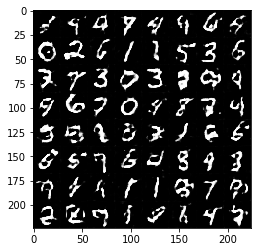

In [16]:
import cv2
import matplotlib.pyplot as plt

im = cv2.imread('/content/results/mnist/LSGAN/LSGAN_epoch001.png')
im_resized = cv2.resize(im, (224, 224), interpolation = cv2.INTER_LINEAR)

plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.show()

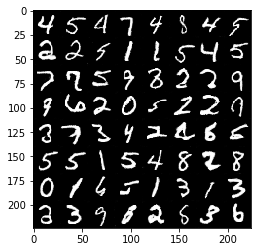

In [17]:
im = cv2.imread('/content/results/mnist/LSGAN/LSGAN_epoch050.png')
im_resized = cv2.resize(im, (224, 224), interpolation = cv2.INTER_LINEAR)

plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.show()

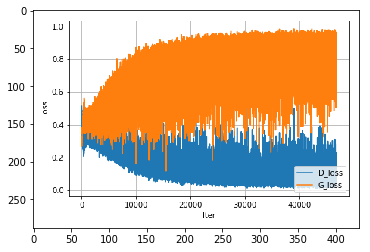

In [18]:
import matplotlib.image as mpimg

img = mpimg.imread('/content/models/mnist/LSGAN/LSGAN_loss.png')
imgplot = plt.imshow(img)
plt.show()